# 12/28/23 - This notebook tests the module "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/total_mass_mge.py
## I'm trying to determine how the mass is producing the wrong kinematic profile.

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
#plt.switch_backend('agg')
%matplotlib inline
import pandas as pd
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

import astropy.units as u
import astropy.constants as constants

# jampy
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [5]:
c2_4piG

<Quantity 1.66291654e+12 solMass / pc>

In [6]:
# bring in the total_mass_mge module

from total_mass_mge import total_mass_mge

In [4]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'

print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']


In [5]:
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

In [6]:
###############################################################################

# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, cov_matrix, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.cov_matrix=cov_matrix
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff
        
        
###############################################################################


def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy_with_cov.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    try:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    except:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    try:
        dVrms_bin = tommy_pickles.dVrms_bin 
    except:
        dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    try: 
        cov_matrix = tommy_pickles.cov_matrix
    except:
        cov_matrix=1
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, cov_matrix, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [7]:
# get all the info for one of the objects

obj_name = obj_names[1] # j0037
SN = 15
file_dir = f'{kinematics_dir}{obj_name}/target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'

surf, sigma, qobs,  \
    kcwi_sigmapsf, Vrms, dVrms, \
    cov_matrix, V_bin, dV_bin, \
    xbin, ybin, reff = prepare_to_jam(obj_name, file_dir, SN)

In [8]:
# lens model power law info

lens_models_chinyi = pd.read_csv(f'{tables_dir}lens_models_table_chinyi.csv')
lens_models_chinyi_sys = pd.read_csv(f'{tables_dir}lens_models_table_chinyi_with_sys.csv')
lens_models_anowar = pd.read_csv(f'{tables_dir}lens_models_table_anowar.csv')

In [424]:
# set up reasonable mass parameters

zlens = slacs_ix_table[slacs_ix_table['Name']==obj_name]['z_lens']
zsource = slacs_ix_table[slacs_ix_table['Name']==obj_name]['z_src']
gamma = lens_models_chinyi_sys[lens_models_chinyi_sys['obj_name']==obj_name]['gamma'].values[0]
f_dm = 0
theta_E = lens_models_chinyi_sys[lens_models_chinyi_sys['obj_name']==obj_name]['theta_E'].values[0]
k_mst = 0.8
a_mst = 7
lambda_int = 1.0

# Get the effective shape and (not) effective radius from the half-light isophote
_, _, eps_eff, _ = mge_half_light_isophote(surf, sigma, qobs)
qobs_eff = 1 - eps_eff

In [425]:
u.arcsec.to('radian')

4.84813681109536e-06

In [426]:
# mass profile as total mass with other pieces

################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.switch_backend('agg')
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )

# astronomy/scipy
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import astropy.units as u
import astropy.constants as constants

# mge fit
import mgefit
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.mge_print_contours import mge_print_contours

# my functions
#import sys
#sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')

class total_mass_mge:
    
    '''
    Class purpose
    ----------------
    
    Return a mass profile designated by input parameters for use in JAM modeling. Uses MGE and JAM modules.
    
    Input Parameters
    ----------------
    
    surf_lum: array_like with shape (nlum)
        peak surface brightness of each MGE component of the surface brightness profile
        
    sigma_lum: array_like with shape (nlum)
        sigma of MGE component of the surface brightness profile
        
    qobs_lum: array_like with shape (nlum)
        axis ratio of each MGE component of the surface brightness profile
    
    model: str
        tells which total mass profile model to use (usually "power_law")
    
    qobs_eff: float
        effective axis ratio of observed 2d surface brightness profile, measured from MGE isophotes
        
    reff: float
        half-light radius of observed 2d surface brightness profile, measured from MGE isophotes
        
    break_factor: float
        factor of the effective radius (reff) at which to truncate the mass profile (should be much higher than radius of kinematic data)
        
    zlens, zsource: float
        redshift of lens and background source, needed for surface mass calculation (distances)
        
    cosmo: astropy.cosmology instance
        describes the cosmology used to get the distance for teh surface mass calculation
        
    gamma: float
        pure power law slope for mass profile, parameter fit in MCMC
        
    f_dm: float
        fraction of dark matter, not needed for power law
        
    theta_E: float
        einstein radius, in arcsec, parameter fit in MCMC
        
    k_mst: float
        scale of mass sheet parameter lambda_int in range(min, max) allowed by the mass profile, parameter fit in MCMC
        
    a_mst: float
        scale of mass sheet truncation in units of reff, parameter fit in MCMC
        
    lambda_int: float
        lambda_int, will override k_mst if specified
        
    Optional Keywords
    --------------
    
    ngauss: int
        number of gaussians for 1d MGE of surface mass profile
    
    inner_slope, outer_slope: int
        constraints to help MGE get itself right at the very center and very end of the profile
        
    quiet: 0 or 1
        makes the output quieter
        
    plot: boolean
        plot things in MGE
    
    skip_mge: boolean
        if true, doesn't do the mge fit, useful just to return the mass profile to look at it
        
    Output Parameters
    --------------
    
    Stored as attributes of total_mass_mge class
    
    .surf_pot
        peak surface mass density of MGE components
    
    .sigma_pot
        sigma of surface mass density MGE components
    
    .qobs_pot
        axis ratio of surface mass density components (2D projection)

    '''
    
    # initialize with self and inputs
    def __init__(self, 
                 surf_lum, sigma_lum, qobs_lum, 
                 model, qobs_eff, reff, break_factor, zlens, zsource, cosmo,
                 gamma, f_dm, theta_E, k_mst, a_mst, lambda_int=None, 
                 ngauss=30, inner_slope=2, outer_slope=3, 
                 quiet=1, plot=False, skip_mge=False):
        
        # luminosity MGE decomponsition
        self.surf_lum = surf_lum
        self.sigma_lum = sigma_lum
        self.qobs_lum = qobs_lum
        self.nlum = surf_lum.shape[0]
        # options/specifics of the object
        self.model = model
        self.qobs_eff = qobs_eff
        self.reff = reff
        self.break_factor = break_factor
        self.rbreak = reff*break_factor
        self.zlens = zlens
        self.zsource = zsource
        # parameters that describe mass profile
        self.gamma = gamma
        self.f_dm = f_dm
        self.theta_E = theta_E
        self.k_mst = k_mst
        self.lambda_int = lambda_int
        self.a_mst = a_mst
        
        # value of c^2 / 4 pi G
        c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')        
        # profile set up
        # The fit is performed in log spaced radii from 1" to 10*rbreak
        n = 1000     # Number of values to sample the gNFW profile for the MGE fit
        self.r = np.geomspace(0.01, self.rbreak, n)   # logarithmically spaced radii in arcsec
        
        # fit the initial mass model
        if model=='power_law':
            
            self.power_law()
        
        # transform by mass sheet
        self.mass_sheet_transform()
        
        if skip_mge == False:
            # get surface mass density by dividing by sigma crit
            self.convergence_to_surf_mass_density()

            # get 1d mge profile
            m = mge_fit_1d(self.r, self.surf_mass_density, ngauss=ngauss, inner_slope=inner_slope, outer_slope=outer_slope, quiet=quiet, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
            surf_pot_tot, sigma_pot = m.sol           # total counts of gaussians Msol/(pc*2/arcsec**2)
            # Normalize by dividing by (2 * np.pi * sigma_pot**2 * q)
            self.surf_pot = surf_pot_tot / np.sqrt(2 * np.pi * sigma_pot**2 * self.qobs_eff) # peak surface density
            self.sigma_pot = sigma_pot
            self.qobs_pot = np.ones_like(self.surf_pot)*self.qobs_eff   # Multiply by q to convert to elliptical Gaussians where sigma is along the major axis...    

    def power_law_check(r, gamma, ):
        return (3 - gamma) / 2 * (theta_E/r)**(gamma-1)
            
    def power_law (self):
        
        """
        Return convergence profile of pure power law profile from parameters
        """
        
        # fit to power law mass density (convergence) profile
        self.kappa_power_law = (3 - self.gamma) / 2 * (self.theta_E/self.r)**(self.gamma-1)
        
    def mass_sheet_transform (self):
        
        '''
        Return transformed convergence profile
        kappa is the convergence profile (surface mass density/critical surface density).
        MST scales by lambda and adds the "infinite" sheet
        kappa_s is the mass sheet
        rs_mst is a "turnover" radius [0,1] (multiplicative factor of rbreak) where it goes to 0, so that it is physical.
        kappa_s = theta_s**2 / (theta_E**2 + theta_s**2)
        Figure 12 from Shajib2023 https://arxiv.org/pdf/2301.02656.pdf
        11/13/23 now, lambda_int will be parameterized as a value k_mst [0,1] that will be transformed into a parameter space allowed by the rest of the model
        '''

        r_s = self.a_mst * self.reff
        kappa_s = r_s**2/(self.r**2 + r_s**2)
        
        if self.lambda_int==None:
            # find the maximum lambda_int possible given the model
            lambda_int_min = 0.8
            lambda_int_max = 1.2
            lambda_ints = np.linspace(1.0,1.2,1000)
            for i, test in enumerate(lambda_ints):
                kappa_bounds = self.kappa_power_law * test + (1 - test) * kappa_s
                if any(kappa_bounds<0):
                    lambda_int_max = lambda_ints[i-1]
                    break

            # calculate surface mass density with mass sheet transform
            self.lambda_int = lambda_int_min + (lambda_int_max - lambda_int_min) * self.k_mst # lambda_int is a value [0,1] so lambda_internal will be between [0.8, lambda_int_max]
        
        # transform using mass sheet
        mass_sheet = (1 - self.lambda_int) * kappa_s
        self.kappa_int = self.lambda_int * self.kappa_power_law + mass_sheet

        if any(self.kappa_int<0):
            print('Somehow, we have negative mass even though we set it up not to.')
            self.lambda_int=0
            
    def convergence_to_surf_mass_density(self):
        # Go from convergence to surface mass density with critical surface density
        # get distances
        DL = cosmo.angular_diameter_distance(self.zlens).to('pc')
        DS = cosmo.angular_diameter_distance(self.zsource).to('pc')
        DLS = cosmo.angular_diameter_distance_z1z2(self.zlens, self.zsource).to('pc')
        # calculate critical surface density
        sigma_crit = c2_4piG * DS / DL / DLS
        self.surf_mass_density = self.kappa_int * sigma_crit.value
        
    
    
        

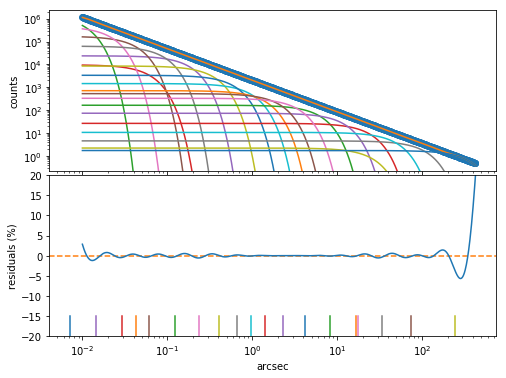

In [427]:
# get total mass profile
break_factor=200

total_mass = total_mass_mge(surf, sigma, qobs, 'power_law', qobs_eff, reff, break_factor, zlens, zsource, cosmo,
                           gamma, f_dm, theta_E, k_mst, a_mst, lambda_int, plot=True)

In [428]:
c2_4piG

<Quantity 1.66291654e+12 solMass / pc>

In [429]:
kcwi_sigmapsf*2.355*2

1.124784760467454

In [433]:
# jam to get velocity

inc=90
mbh=0
distance = cosmo.angular_diameter_distance(zlens).value
ratio = 1.5
beta = np.ones_like(surf)*(1-ratio**2)

jam_zz =  jam_axi_proj(surf_lum=surf, sigma_lum=sigma, qobs_lum=qobs,
            surf_pot=total_mass.surf_pot, sigma_pot=total_mass.sigma_pot, qobs_pot=total_mass.qobs_pot,
            inc=inc, mbh=mbh, distance=distance,
            xbin=xbin.ravel(), ybin=ybin.ravel(), align='sph',
            beta=beta, moment='zz', pixsize=0.1457,
            sigmapsf=kcwi_sigmapsf*2, normpsf=1., plot=True)

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=-1.2; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.898e+12



In [434]:
jam_zz.model[:10]

array([300.60655139, 300.26867046, 300.94955591, 301.36261615,
       299.6997556 , 299.04287729, 300.11368166, 298.74649658,
       300.60655139, 297.50630723])

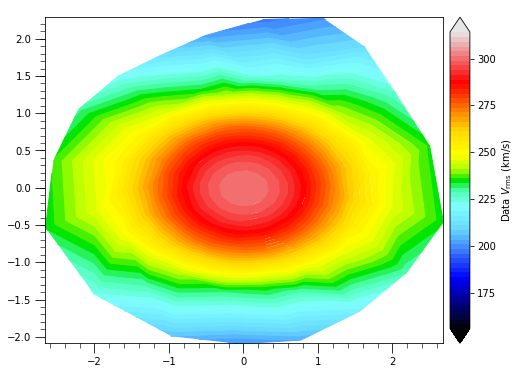

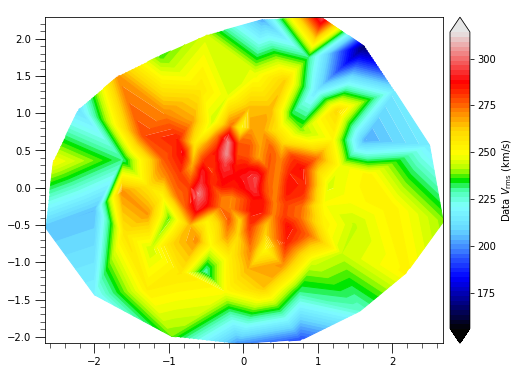

In [435]:
vel_field = jam_zz.model

plot_velfield(xbin, ybin, vel_field, vmin=np.min(Vrms)-10, vmax=np.max(Vrms)+10, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", nodots=True) ;
plt.pause(1)

plt.figure()
plot_velfield(xbin, ybin, Vrms, vmin=np.min(Vrms)-10, vmax=np.max(Vrms)+10, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", nodots=True) ;
plt.pause(1)

In [436]:
np.mean(vel_field)

270.917976740052

In [422]:
# Check the distances
DL = cosmo.angular_diameter_distance(zlens).to('pc')
DS = cosmo.angular_diameter_distance(zsource).to('pc')
DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to('pc')

In [423]:
# SIS
theta_E_rad = theta_E / 206265
sigma_sis_sq = theta_E_rad * constants.c.to('km s-1')**2 * DS / 4 / np.pi / DLS
sigma_sis = np.sqrt(sigma_sis_sq)
sigma_sis

<Quantity [244.34285867] km / s>

In [22]:
sigma_crit = DS / (DL * DLS) * c2_4piG

In [67]:
DL / u.radian.to('arcsec')

<Quantity [3234.59448077] pc>

In [23]:
sigma_crit

<Quantity [3811.34885867] solMass / pc2>

In [33]:
surface_mass_density = sigma_crit.value * total_mass.kappa_int

In [34]:
# integrate over it

In [49]:
# To sum over the surface mass density, I need to get the value of the 
radius_arcsec = reff*break_factor
radius_arcsec

852.4941945850223

In [43]:
"{:e}".format(2*np.pi*np.nansum(surface_mass_density))

'5.001203e+08'

In [26]:
from scipy.integrate import quad

In [62]:
def integrand (r, gamma, theta_E):
    return (3 - gamma) / 2 * (theta_E/r)**(gamma-1) * r *DL.value*u.arcsec.to('radian')

In [71]:
"{:e}".format(2 * np.pi * quad(lambda r: integrand(r, gamma, theta_E), 0, 1000*reff*DL.value*u.arcsec.to('radian'))[0])

'7.005207e+10'

In [45]:
zlens

2    0.195
Name: z_lens, dtype: float64

In [46]:
zsource

2    0.632
Name: z_src, dtype: float64

In [34]:
integral

(812288.1938886122, 9.018210554863207e-09)

In [40]:
surface_mass_density

array([1.16353532e+06, 1.14652688e+06, 1.12976707e+06, 1.11325226e+06,
       1.09697886e+06, 1.08094334e+06, 1.06514222e+06, 1.04957209e+06,
       1.03422956e+06, 1.01911130e+06, 1.00421404e+06, 9.89534545e+05,
       9.75069635e+05, 9.60816171e+05, 9.46771063e+05, 9.32931265e+05,
       9.19293776e+05, 9.05855638e+05, 8.92613937e+05, 8.79565802e+05,
       8.66708403e+05, 8.54038952e+05, 8.41554702e+05, 8.29252946e+05,
       8.17131015e+05, 8.05186281e+05, 7.93416154e+05, 7.81818082e+05,
       7.70389549e+05, 7.59128077e+05, 7.48031224e+05, 7.37096583e+05,
       7.26321784e+05, 7.15704490e+05, 7.05242398e+05, 6.94933241e+05,
       6.84774781e+05, 6.74764816e+05, 6.64901176e+05, 6.55181722e+05,
       6.45604346e+05, 6.36166971e+05, 6.26867550e+05, 6.17704067e+05,
       6.08674535e+05, 5.99776996e+05, 5.91009520e+05, 5.82370206e+05,
       5.73857181e+05, 5.65468598e+05, 5.57202638e+05, 5.49057510e+05,
       5.41031446e+05, 5.33122706e+05, 5.25329575e+05, 5.17650364e+05,
      

In [39]:
integrand(reff)

array([], dtype=float64)